In [50]:
import re
from pathlib import Path
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from wordcloud import WordCloud
from tqdm import tqdm

from nltk import download as nltk_download
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize


# Download necessary NLTK resources
nltk_download("punkt")
nltk_download("stopwords")
nltk_download("wordnet")
nltk_download("averaged_perceptron_tagger")
nltk_download("omw-1.4")

# Initialize stop words
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tylernardone/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Define project directories
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / "data"

# Load data
df = pd.read_csv(DATA_DIR / "intermediate" / "25072024_reviews_openrefine.csv")

In [3]:
def process_text(text: str, processor: Union[WordNetLemmatizer, PorterStemmer]) -> str:
    # Remove numbers
    text = re.sub(r"\d", "", text)

    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())

    # Parts of speech tagging. Nltk pos tags based only on token not on context unlike spacy.
    # Tried spaCy pos tagging and lemmatization but it made no difference on major key words,
    # and nltk is faster.
    tagged_tokens = pos_tag(tokens)

    # Apply the processor (lemmatizer or stemmer). Lemmatizer is better than stemmer.
    if isinstance(processor, WordNetLemmatizer):
        processed_tokens = [
            processor.lemmatize(token, pos=get_wordnet_tag(tag))
            for token, tag in tagged_tokens
        ]
    elif isinstance(processor, PorterStemmer):
        processed_tokens = [processor.stem(token) for token in tokens]
    else:
        raise ValueError(
            "processor must be an instance of either WordNetLemmatizer or PorterStemmer"
        )

    # Join the processed tokens back into a single string and return
    return " ".join(processed_tokens)


def get_wordnet_tag(treebank_tag):
    """
    Return POS tags compliant with WORDENT lemmatization (a,n,r,v)
    """
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

In [4]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# NOTE: PorterStemmer does not work as needed
# NOTE: spaCy lemmatization provides basically the same results as nltk WordNetLemmatizer

# Apply the text processing function to the "blind_assessment" column
df["cleaned_assessment"] = df["blind_assessment"].apply(
    process_text, processor=lemmatizer
)

In [5]:
# Apply TF-IDF vectorization to cleaned_assessment column
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df["cleaned_assessment"]) # -> scipy sparse matrix

# View keywords
feature_names = vectorizer.get_feature_names_out()

print(feature_names)

<class 'scipy.sparse._csr.csr_matrix'>


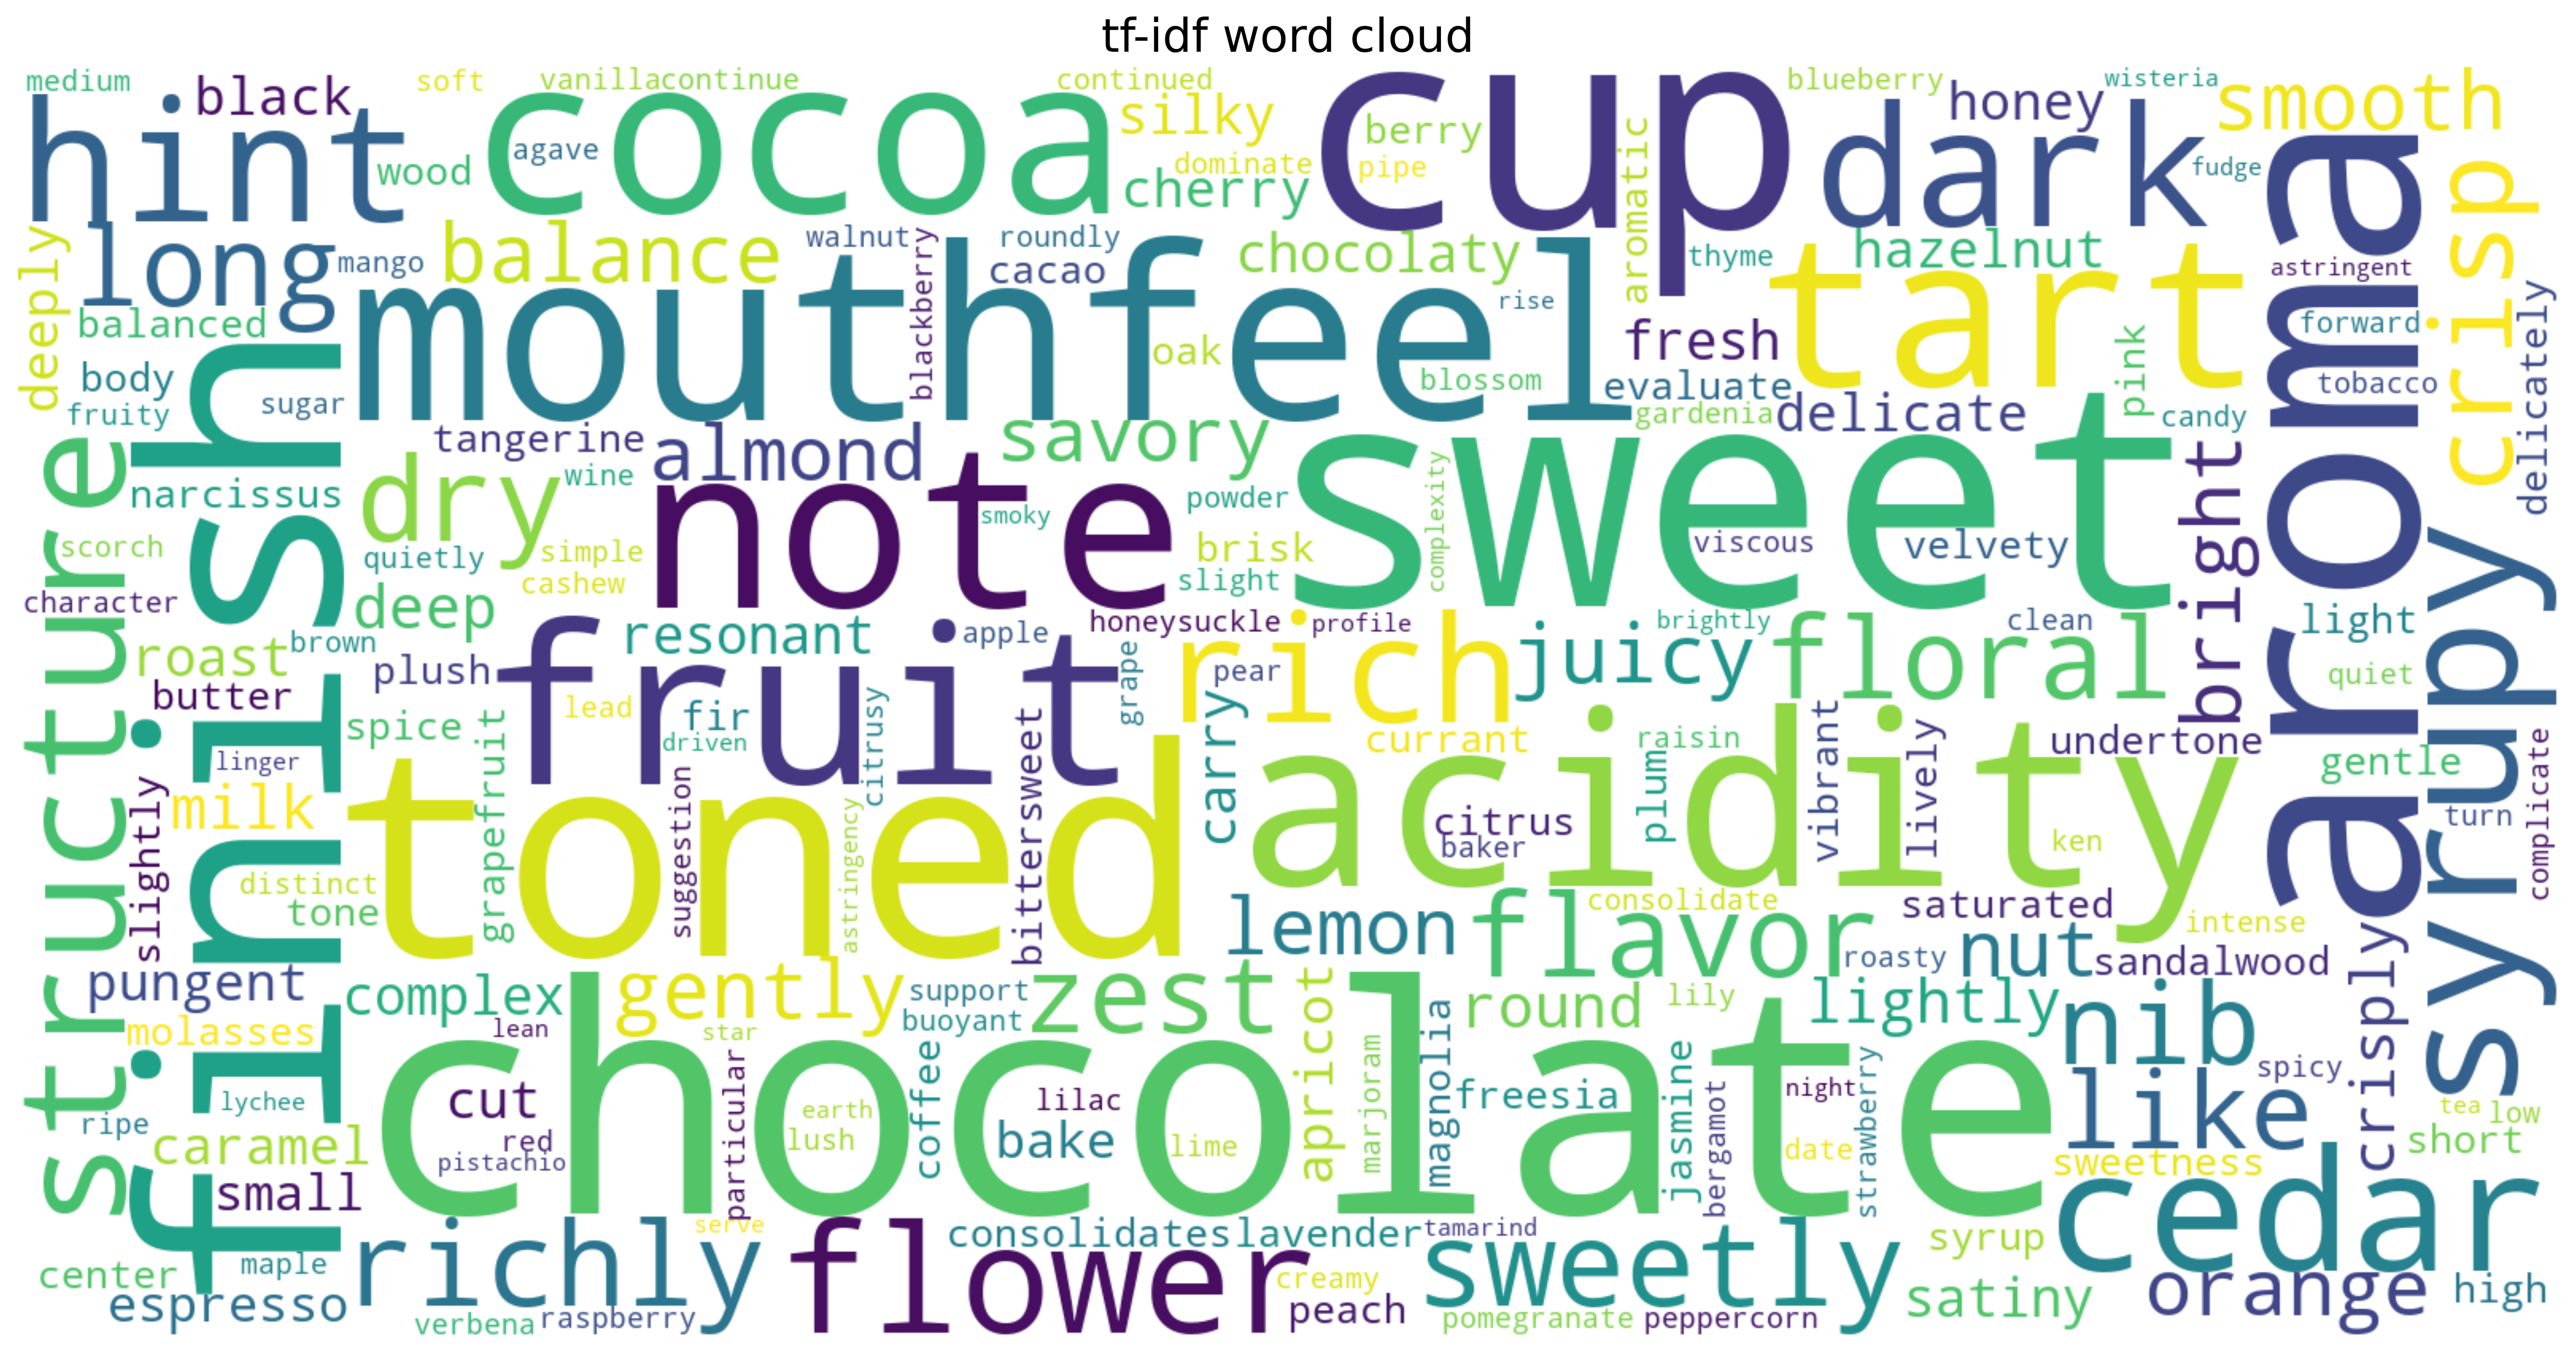

In [57]:
# Create a wordcloud of top keywords
output_path = BASE_DIR / "imgs" / "blind_assessment_tfidf_wordcloud.png"

# Sum the TF-IDF scores for each word
tfidf_scores = tfidf_matrix.mean(axis=0).A1
word_scores = dict(zip(feature_names, tfidf_scores))


# Create and display the word cloud
wordcloud = WordCloud(
    width=1600, height=800, background_color="white", max_font_size=200
)
wordcloud.generate_from_frequencies(word_scores)

# Plot the word cloud
plt.figure(figsize=(20, 10), dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("tf-idf word cloud", fontsize=20)
plt.savefig(output_path, bbox_inches="tight")
plt.show()

In [60]:
sorted_keywords = sorted(word_scores.items(), key=lambda item: item[1], reverse=True)

sorted_keywords

[('chocolate', 0.06379674164751936),
 ('sweet', 0.062152374118708185),
 ('toned', 0.053462116968995395),
 ('cup', 0.051155715009922345),
 ('aroma', 0.04845018055432538),
 ('finish', 0.04836195815547614),
 ('mouthfeel', 0.047719480285367176),
 ('acidity', 0.04695425568454884),
 ('note', 0.04215757938981177),
 ('cocoa', 0.039618102357687195),
 ('fruit', 0.03915838151131436),
 ('tart', 0.03644007726314099),
 ('cedar', 0.03601897204088074),
 ('dark', 0.034432520663001016),
 ('hint', 0.034136460076795536),
 ('syrupy', 0.03378847053831659),
 ('flower', 0.03367959443716852),
 ('structure', 0.03224992556895786),
 ('rich', 0.03210491977955505),
 ('sweetly', 0.030891543484611286),
 ('dry', 0.030633846214791937),
 ('richly', 0.030494354128687062),
 ('flavor', 0.02993315124201786),
 ('nib', 0.028470263561071945),
 ('crisp', 0.02835136386377313),
 ('floral', 0.028312035213540997),
 ('long', 0.027399982066847742),
 ('zest', 0.025955536534972855),
 ('like', 0.02488118070701256),
 ('gently', 0.0243541

n conclusions, use t-SNE for visualization (and try different parameters to get something visually pleasing!), but rather do not run clustering afterwards, in particular do not use distance- or density based algorithms, as this information was intentionally (!) lost. Neighborhood-graph based approaches may be fine, but then you don't need to first run t-SNE beforehand, just use the neighbors immediately (because t-SNE tries to keep this nn-graph largely intact).

## Clustering

We will two clustering algorithms: Kmeans and DBSCAN. Each will run on the original tf-ifd vectors and on PCA reduced vectors.

Clusters will be visualized in 2D using t-SNE. Note that t-SNE should not be used for dimensionality reduction and only for producing visualizations.

### PCA

Dimensionality reduction can be helpful for clustering methods as they are typically sensitive to the *curse of dimensionality*.


### Kmeans

Kmeans is a simple clustering algorithm that partitions the data into k clusters where k must be specified. To determine the optimal number of clusters, we will use the elbow method.
This method consists of plotting the sum of squared distances between each point and the centroid of the cluster it belongs to. The optimal number of clusters is the point where the curve starts to flatten out. With the optimal k value, we will run Kmeans on the original tf-idf vectors and on PCA reduced data. 

### DBSCAN

DBSCAN is a density-based clustering algorithm that groups together points that are closely packed together. It is able to find clusters of arbitrary shapes and sizes. DBSCAN has two parameters: epsilon and min_samples. Epsilon is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Min_samples is the number of samples in a neighborhood for a point to be considered as a core point. Epsilon is the most important parameter to tune. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection

### HDBSCAN

HDBSCAN is a hierarchical version of DBSCAN. It is able to find clusters of varying densities and sizes. It has two parameters: min_cluster_size and min_samples. Min_cluster_size is the smallest size grouping that should be considered a cluster. Min_samples is the number of samples in a neighborhood for a point to be considered as a core point. HDBSCAN is much more than scale invariant though – it is capable of multi-scale clustering, which accounts for clusters with varying density. Traditional DBSCAN assumes that any potential clusters are homogeneous in density. HDBSCAN is free from such constraints.

### t-SNE
t-SNE is a manifold learning method for visualizing high-dimensional data. It maps the high-dimensional data to a 2D or 3D space so that the data points that are close in the high-dimensional space remain close in the low-dimensional space. t-SNE is generally not recommended for dimensionality reduction as it does not preserve global structure and distances.

https://distill.pub/2016/misread-tsne/


### UMAP

Notes on umap, tf-ifd for text analysiss and visulization

https://umap-learn.readthedocs.io/en/latest/sparse.html

### Can I cluster the results of UMAP?

This is hard to answer well, but essentially the answer is “yes, with care”. To start with it matters what clustering algorithm you are going to use. Since UMAP does not necessarily produce clean spherical clusters something like K-Means is a poor choice. I would recommend HDBSCAN or similar. The catch here is that UMAP, with its uniform density assumption, does not preserve density well. What UMAP will do, however, is contract connected components of the manifold together. Providing you have enough data for UMAP to distinguish that information then you can get useful clustering results out since algorithms like HDBSCAN will easily pick out the components after applying UMAP.

UMAP does offer significant improvements over algorithms like t-SNE for clustering. First, by preserving more global structure and creating meaningful separation between connected components of the manifold on which the data lies, UMAP offers more meaningful clusters. Second, because it supports arbitrary embedding dimensions, UMAP allows embedding to larger dimensional spaces that make it more amenable to clustering.

Consider a typical pipeline: high-dimensional embedding (300+) => PCA to reduce to 50 dimensions => UMAP to reduce to 10-20 dimensions => HDBSCAN for clustering / some plain algorithm for classification;

data -> pre-process -> tf-idf vectors

Then... 

Kmeans (silhouette scores) -> t-SNE, UMAP

PCA -> Kmeans (silhouette scores) -> t-SNE, UMAP

PCA -> HDBSCAN -> t-SNE, UMAP

PCA -> UMAP -> HDBSCAN -> t-SNE, UMAP 


Text(0, 0.5, 'cumulative explained variance')

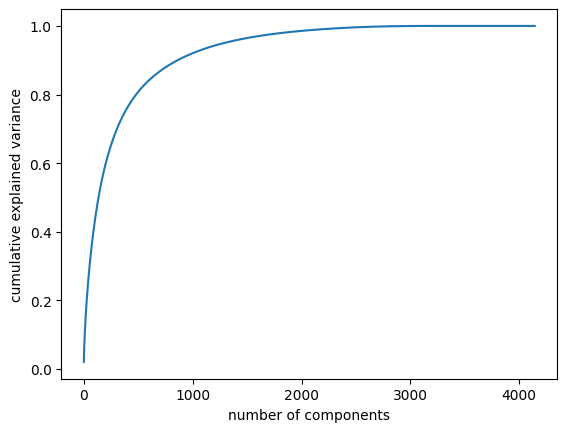

In [41]:
# df - read in data
# tfidf_matrix - matrix of tfidf values
# vectorizer - object returned by TfidfVectorizer that contains the feature names and scores

# Kmeans clustering
X = tfidf_matrix.toarray()

pca = PCA()
X_pca = pca.fit_transform(X)

# plot explained variance ratiio

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')



In [43]:
# keep 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
print(f"Number of components to keep: {n_components}")

# keep the first n_components from our pca
X_pca = X_pca[:, :n_components]
X_pca.shape

Number of components to keep: 1286


(7563, 1286)

In [11]:
# Use silhouette score to determine the number of clusters
silhouette_scores = []
K = range(30, 100)

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    cluster_labels = kmeans.predict(X_pca)
    silhouette = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette)
    
# number of clusters with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]

100%|██████████| 70/70 [03:02<00:00,  2.61s/it]


In [13]:
px.line(x=K, y=silhouette_scores,  
        height=400, width=800, labels={"x": "Number of Clusters", "y": "Silhouette Score"})

In [14]:
# number of clusters with the highest silhouette score
best_k = K[np.argmax(silhouette_scores)]

kmeanModel = KMeans(n_clusters=best_k).fit(X_pca)
cluster_labels = kmeanModel.predict(X_pca)

In [47]:
# Perform t-SNE on the PCA features to visualize the clusters
tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42)
tsne_features = tsne.fit_transform(X_pca)

/Users/tylernardone/Projects/coffee-review/venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [48]:
tsne_df = pd.DataFrame(
    tsne_features, columns=["component1", "component2"]
)

tsne_df["cluster"] = cluster_labels
tsne_df["cluster"] = tsne_df["cluster"].astype(str)
tsne_df["country"] = df["origin_country"]
tsne_df["rating"] = df["rating"]

fig = px.scatter(
    tsne_df,
    x="component1",
    y="component2",
    color="cluster",
    # hover shows country and rating
    hover_data={"cluster": True, "country": True, "rating": True},
    height=800,
    width=1200,

)

fig.show()

In [ ]:
# Kmeans 
# Kmeans after PCA
# DBSCAN - fine tune the hyperparameters
# DBSCAN with cosine metric

# Plot the clusters using t-SNE, and fine-tuning 

## Dimensionality Reduction and Visualization
t-SNE
PCA